In [1]:
import torch
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

from edunets import functions
from edunets.nn import Linear
from edunets.tensor import Tensor

(<matplotlib.image.AxesImage at 0x7f336be63970>, 5)

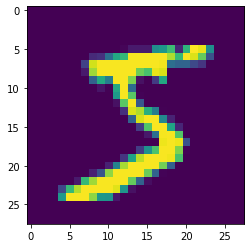

In [2]:
# load the mnist dataset

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

plt.imshow(X_train[0]), Y_train[0]

In [14]:
class EduNet1:
    def __init__(self):
        self.l1 = Tensor.uniform(784, 128, requires_grad=True)
        self.l2 = Tensor.uniform(128, 10, requires_grad=True)

    def __call__(self, x):
        x = x @ self.l1
        x = x.relu()
        x = x @ self.l2
        return x

# Mean Square Error
def MSELOSS(y_out, y_pred):
    return sum((yo - yp)**2 for yo, yp in zip(y_out, y_pred))

# Stochastic gradient descent
class SGD:
    def __init__(self, params, lr=0.001):
        self.lr = lr
        self.params = params

    def step(self):
        for t in self.params:
            t.assign(t - t.grad * self.lr)

    def zero_grad(self):
        for param in self.params:
            param.grad = None

In [15]:
model = EduNet1()

optim = SGD([model.l1, model.l2], lr=0.001)
batch_size = 128
losses, accuracies = [], []

print(model.l1)

for i in (t := trange(1)):
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))

    X = Tensor(X_train[samp].reshape((-1, 28*28)))

    Y = Tensor(Y_train[samp])

    out = model(X)
    
    cat = functions.argmax(out, axis=1)
    
    accuracy = (cat == Y).mean()
    
    loss = MSELOSS(out, Y)

    loss = loss.mean()

    optim.zero_grad()
    
    loss.backward()
  
    optim.step()
  
    loss, accuracy = loss.data, accuracy.data
    
    losses.append(loss)
    
    accuracies.append(accuracy)
    
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

print(model.l1)

tensor([[ 0.0814701 ,  0.536772  ,  0.8949093 , ..., -0.67677695,
        -0.36530912,  0.17156687],
       [-0.18789046,  0.3676868 , -0.8283528 , ..., -0.33469132,
        -0.7368785 , -0.37503543],
       [ 0.02356216, -0.88826203,  0.59719044, ..., -0.04754621,
         0.77539676, -0.01322015],
       ...,
       [-0.44846648,  0.06039368, -0.32445136, ..., -0.26790228,
         0.0038232 , -0.5506459 ],
       [-0.1580628 ,  0.94253516, -0.6394429 , ..., -0.09471776,
        -0.5028727 , -0.6317588 ],
       [ 0.94820964, -0.55557656,  0.9499455 , ..., -0.40651512,
         0.16935429,  0.31234303]], dtype=float32, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'